In [1]:
using PyCall
using ProfileView
using Polynomials

In [2]:
tolerance = 1e-6
maxiter = 100

100

In [3]:
function newton_find_root(p :: Poly{Float64}, p_der :: Poly{Float64}, point :: Complex{Float64})
    val ::Complex{Float64} = polyval(p, point)
    niter :: Int = 0
    while abs(real(val^2)) > tolerance && niter < maxiter
        point = point - val / polyval(p_der, point)
        val = polyval(p, point)
        niter += 1
    end
    return round(point, 2), niter
end

newton_find_root (generic function with 1 method)

In [65]:
function plot_for(p :: Poly{Float64}; min_x = -5., max_x = 5., steps=100, min_y = -5., max_y = 5.)
    der = polyder(p)
    r = roots(p)

    total = steps*steps
    dot_each = total / 100
    Xs = linspace(min_x, max_x, steps)
    Ys = linspace(min_y, max_y, steps)
    res = SharedArray(Float64, (steps, steps, 2))
    iter = 0
    max = steps-2
    for i in 1:max
        for j in 1:max
            zero, iters = newton_find_root(p, der, Xs[i] +  1.im * Ys[j])
            zero_index = indmin(abs((r-zero)))
            res[j,i,1] = zero_index
            res[j,i,2] = iters
            iter += 1
            if iter % dot_each == 0
                print(".")
            end
        end
    end

    return Xs, Ys, res
end

plot_for (generic function with 1 method)

In [67]:
p = Poly([1.,0.,0.,0.,2., 1.])

Poly(1.0 + 2.0x^4 + x^5)

In [75]:
r = roots(p)
x, y = real(r[1]), 0

(0.5821701007901727,0)

In [76]:
@time res = plot_for(p, steps=1000, min_x = x - 1, max_x = x + 1, min_y = y - 1, max_y = y + 1)
""

...................................................................................................

""

  5.203467 seconds (53.11 M allocations: 1.252 GB, 3.76% gc time)


In [7]:
Profile.clear()
@profile plot_for(p, steps=200)
""

6.894492 seconds (55.40 M allocations: 1.309 GB, 2.39% gc time)
....................................................

""

..............................................

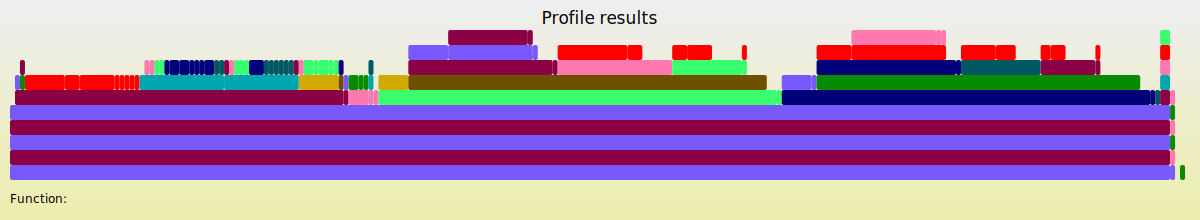

In [8]:
ProfileView.view()

In [9]:
using Images, Colors, FixedPointNumbers, ImageView

  likely near /home/luki/.julia/v0.4/ImageView/src/annotations.jl:43
  likely near /home/luki/.julia/v0.4/ImageView/src/annotations.jl:43
  likely near /home/luki/.julia/v0.4/ImageView/src/annotations.jl:61
  likely near /home/luki/.julia/v0.4/ImageView/src/annotations.jl:61
  likely near /home/luki/.julia/v0.4/ImageView/src/annotations.jl:61
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/luki/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/luki/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading /home/luki/.julia/v0.4/ImageView/src/annotations.jl, in expression starting on line 96
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/luki/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/luki/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at 

In [73]:
function add_alpha(c, alpha)
    a = round(UInt8, 255 - 200*alpha)
    r = round(UInt8, a*c[1])
    g = round(UInt8, a*c[2])
    b = round(UInt8, a*c[3])
    return RGBA{U8}(r,g,b, 1.)
end

function plot_with_pil(arg; width=150, additional_alpha=0.1)
    Xs, Ys, res = arg
    min_x = Xs[1]
    max_x = reverse(Xs)[1]
    width_x = max_x - min_x
    
    min_y = Ys[1]
    max_y = reverse(Ys)[1]
    width_y = max_y - min_y
    
    pointx_to_plot(p) = round(Int, 1+width*(p-min_x)/width_x)
    pointy_to_plot(p) = round(Int, 1+width*(p-min_y)/width_y)
    x_y_to_plot(x,y) = (pointx_to_plot(x), pointy_to_plot(y))
    unit_width = abs(pointx_to_plot(Xs[1]) - pointx_to_plot(Xs[2]))
    
    colors = [(0., 0., 1.),
              (0., 1., 0.),
              (1., 0., 0.),
              (1., 0., 1.),
              (0., 1., 1.),
              (1., 1., 0.),
              (1., 0.5, 0.),
              (0., 0.5, 1.),
              (0.5, 1., 0.)]
    
    iters = res[:,:,2][:]
    max_iters = iters[indmax(iters)]
    min_iters = iters[indmin(iters)]
    width_iters = max_iters - min_iters
    alpha(iters) = 0.95^(iters-min_iters)
    res_to_rgb(zero, iters) = add_alpha(colors[convert(Int, zero)+1], additional_alpha+alpha(iters))
    
    w, h = width, width
    
    img = Array{RGBA{UFixed8}}((w+1, h+1))
    
    total = length(Xs) * length(Ys)
    each_num = total / 100
    
    iter = 0

    for i in (1:length(Xs))
        for j in reverse(1:length(Ys))
            x,y = x_y_to_plot(Xs[i],Ys[j])
            c = res_to_rgb(res[j,i,1], res[j,i,2])
            img[x, y] = c
            
            iter += 1
            if iter % each_num == 0
                print(".")
            end
           # for tx in max(x-unit_width, 1):min(x+unit_width, w)
           #     for ty in max(y-unit_width, 1):min(y+unit_width, h)
           #         img[tx, ty] = c
           #     end
           # end
        end
    end

    # draw axis  
    #for x in 1:w
    #    img[x, div(h,2)] = RGBA{UFixed8}(1.,1.,1.,1.)
    #end
    #for y in 1:h
    #    img[div(w,2), y] = RGBA{UFixed8}(1.,1.,1.,1.)
    #end
    
    Image(img)
end

plot_with_pil (generic function with 1 method)

.............................................................................................

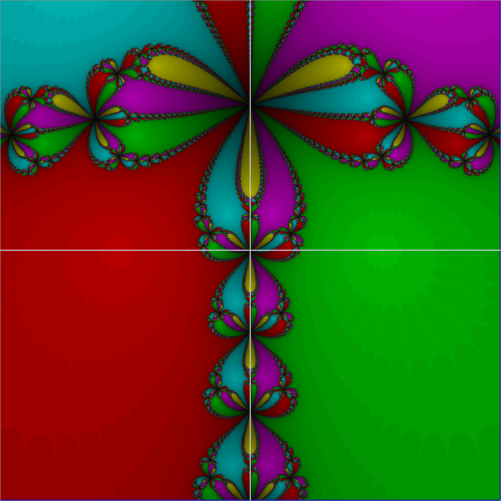

.......

In [77]:
i = plot_with_pil(res, width=1000, additional_alpha=0)

In [80]:
function plot_and_save(file, min_x, max_x, min_y, max_y)
    println("\n", file)
    println("Calculating..")
    res = plot_for(p, steps=1000, min_x = min_x, max_x = max_x, min_y = min_y, max_y = max_y)
    println("\nPlotting..")
    i = plot_with_pil(res, width=1000, additional_alpha=0)
    save(file, i)
    println("\nDone.")
end

plot_and_save (generic function with 2 methods)

In [88]:
@time plot_and_save("test.png", x, x+1.75, -1., 1.)


test.png
Calculating..
...................................................................................................
Plotting..
....................................................................................................
Done.
  7.019582 seconds (72.85 M allocations: 1.617 GB, 4.05% gc time)


In [93]:
sp = linspace(0.1, 2, 100)
@sync @parallel for i=1:100
    xd = sp[i]^2 + sp[101 - i]^2
    plot_and_save((@sprintf "%03d.png" i), -1.0 * xd + x, xd + x + 1.75, -1. * xd, xd)
end


001.png
Calculating..
...................................................................................................
Plotting..
....................................................................................................
Done.

002.png
Calculating..
...................................................................................................
Plotting..
....................................................................................................
Done.

003.png
Calculating..
...................................................................................................
Plotting..
....................................................................................................
Done.

004.png
Calculating..
...................................................................................................
Plotting..
....................................................................................................
Done.

005.png
Calculating..
.............

1-element Array{Any,1}:
 RemoteRef{Channel{Any}}(1,1,542)